In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
%matplotlib inline

mpl.rcParams['figure.figsize'] = [12, 5]
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 12

## Loading data

In [3]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [4]:
(market_train_df, news_train_df) = env.get_training_data()

## Market data EDA

In [5]:
market_train_df.head(3)

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0


In [6]:
market_train_df.shape

(4072956, 16)

In [7]:
market_train_df.columns

Index(['time', 'assetCode', 'assetName', 'volume', 'close', 'open',
       'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10', 'universe'],
      dtype='object')

In [8]:
print("The market data cover stock stats from: {} to {}."
      .format(market_train_df.time.min(),market_train_df.time.max()))

The market data cover stock stats from: 2007-02-01 22:00:00+00:00 to 2016-12-30 22:00:00+00:00.


In [9]:
market_train_df = market_train_df.sort_values('time')
market_train_df['date'] = market_train_df['time'].dt.date

Trends of closing prices by quantiles

Text(0.5,1,'Market closing price by quantile')

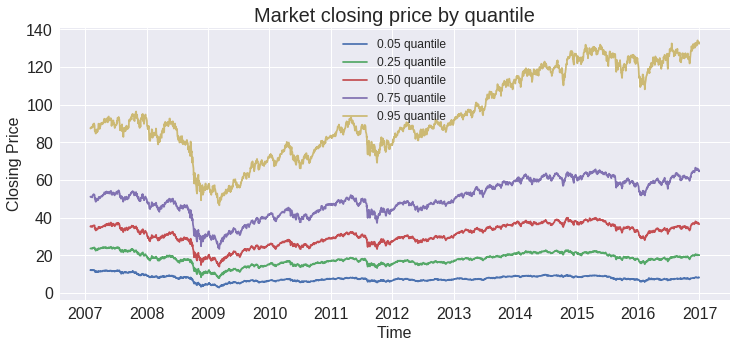

In [10]:
# inspired by https://www.kaggle.com/dmdm02/complete-eda-voting-lightgbm
for i in [0.05,0.25, 0.5, 0.75,0.95]:
    close_df = market_train_df.groupby('date')['close'].quantile(i).reset_index()
    plt.plot(close_df['date'], close_df['close'], label='%.2f quantile' %i)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Market closing price by quantile')

Number of assets by trading day.

Text(0.5,1,'Number of assets by trading day')

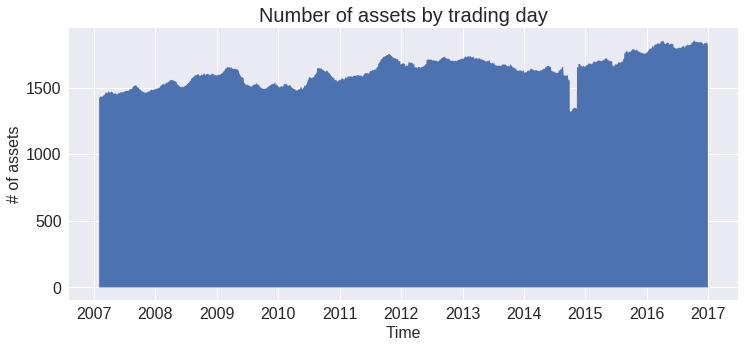

In [11]:
assets_by_day = market_train_df.groupby(market_train_df['date'])['assetCode'].nunique()

plt.fill_between(assets_by_day.index,0,assets_by_day.values)
#plt.plt(assets_by_day)

plt.xlabel('Time')
plt.ylabel('# of assets')
plt.title('Number of assets by trading day')


Trading volumes by day.

Text(0.5,1,'Trading volumes by day')

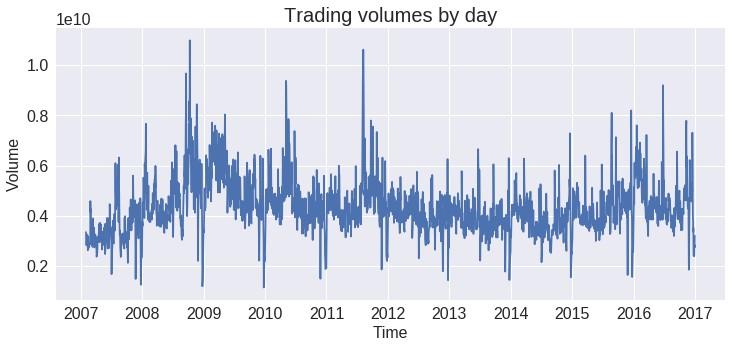

In [12]:
volume_by_day = market_train_df.groupby(market_train_df['date'])['volume'].sum()

plt.plot(volume_by_day) #or barchart (x=volume_by_day.index, y=volume_by_day.values)
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('Trading volumes by day')

Target: returnsOpenNextMktres10 (Market-residualized open-to-open returns in the next 10 days).


In [13]:
market_train_df['returnsOpenNextMktres10'].describe()

count    4.072956e+06
mean     1.405528e-02
std      7.242467e+00
min     -1.375045e+03
25%     -2.970509e-02
50%      1.044642e-03
75%      3.152750e-02
max      9.761338e+03
Name: returnsOpenNextMktres10, dtype: float64

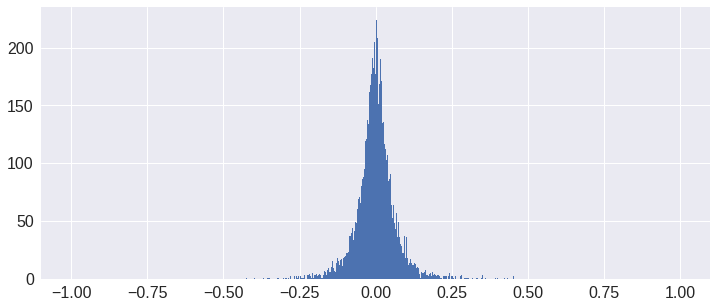

In [14]:
target_hist = plt.hist(market_train_df['returnsOpenNextMktres10'].sample(n=10000),
                       bins=1000,
                       range=(-1,1))

Outliers do exist, but most are in the -1 to 1 range.

## News data EDA

In [15]:
news_train_df.head(3)

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3,1,RTRS,"{'ENR', 'ASIA', 'CN', 'NGS', 'EMRG', 'RTRS', '...","{'Z', 'O', 'OIL'}",1438,1,,False,11,275,"{'0857.HK', '0857.F', '0857.DE', 'PTR.N'}",PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
1,2007-01-01 07:03:35+00:00,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3,1,RTRS,"{'FEA', 'CA', 'LATAM', 'MX', 'INS', 'ASIA', 'I...","{'PGE', 'PCO', 'G', 'ESN', 'MD', 'PCU', 'DNP',...",4413,1,FEATURE,False,55,907,{'STA.N'},Travelers Companies Inc,8,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3
2,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3,1,RTRS,"{'RET', 'ENR', 'ID', 'BG', 'US', 'PRESS', 'IQ'...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",2108,2,PRESS DIGEST,False,15,388,"{'WMT.DE', 'WMT.N'}",Wal-Mart Stores Inc,14,0.377964,-1,0.450049,0.295671,0.254280,67,0,0,0,0,0,0,0,5,11,17


In [16]:
news_train_df.shape

(9328750, 35)

In [17]:
news_train_df.columns

Index(['time', 'sourceTimestamp', 'firstCreated', 'sourceId', 'headline',
       'urgency', 'takeSequence', 'provider', 'subjects', 'audiences',
       'bodySize', 'companyCount', 'headlineTag', 'marketCommentary',
       'sentenceCount', 'wordCount', 'assetCodes', 'assetName',
       'firstMentionSentence', 'relevance', 'sentimentClass',
       'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
       'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D',
       'volumeCounts7D'],
      dtype='object')

In [18]:
print("The news data cover news stats from: {} to {}."
      .format(news_train_df.time.min(),news_train_df.time.max()))

The news data cover news stats from: 2007-01-01 04:29:32+00:00 to 2016-12-30 22:00:00+00:00.


In [19]:
# Sort values by time then extract date
news_train_df = news_train_df.sort_values(by='time')
news_train_df['date'] = news_train_df['time'].dt.date

Top 10 news provider.

In [20]:
news_train_df['provider'].value_counts().head(10)

RTRS    7287840
PRN      687327
BSW      659798
MKW      171630
GNW      156367
RNS      119591
LSE       64250
HIIS      61921
CNW       46459
ONE       25233
Name: provider, dtype: int64

News count by day.

Text(0.5,1,'Count by day')

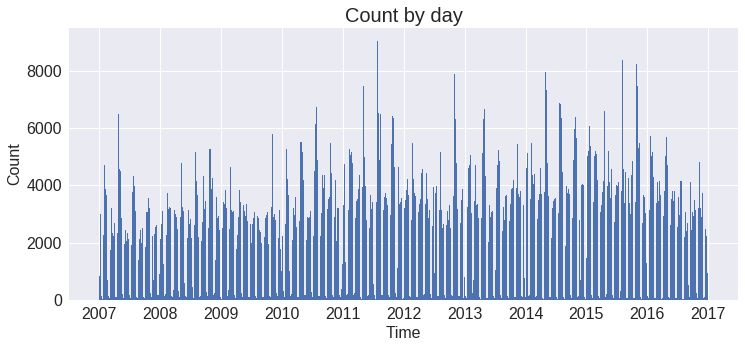

In [21]:
count_by_day = news_train_df.groupby('date')['sourceId'].count()
#count_by_day = count_by_day.ewm(span=10).mean()

plt.bar(x=count_by_day.index, height=count_by_day.values, width=1)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Count by day')

Top 10 mentioned assets in news.

Text(0.5,0,'News count')

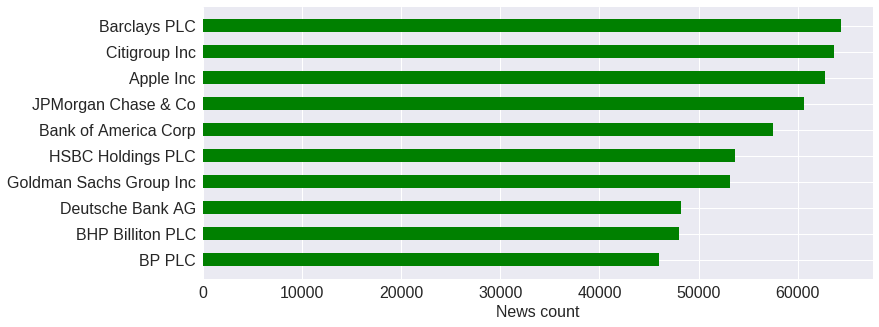

In [33]:
asset_name = news_train_df.groupby('assetName')['sourceId'].count().sort_values(ascending=False)[:10]
plt.barh(y=asset_name.index, width=asset_name.values, height=0.5, color='green')
plt.gca().invert_yaxis()
plt.xlabel('News count')

News words and sentences count.

Text(0.5,0,'Word per sentence')

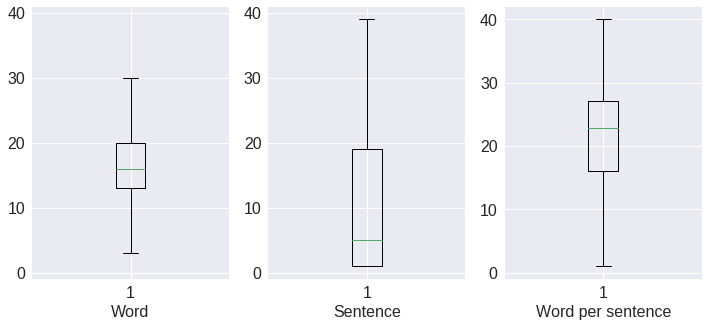

In [34]:
news_train_df['sentence_word_count'] =  news_train_df['wordCount'] / news_train_df['sentenceCount']

plt.subplot(1, 3, 1)
word_count = plt.boxplot(news_train_df['wordCount'][news_train_df['wordCount'] < 40]);
plt.xlabel('Word')

plt.subplot(1, 3, 2)
sen_count = plt.boxplot(news_train_df['sentenceCount'][news_train_df['sentenceCount'] < 40]);
plt.xlabel('Sentence')

plt.subplot(1, 3, 3)
sen_word_count = plt.boxplot(news_train_df['sentence_word_count'][news_train_df['sentence_word_count'] < 40])
plt.xlabel('Word per sentence')


Which attitude prevails in news?

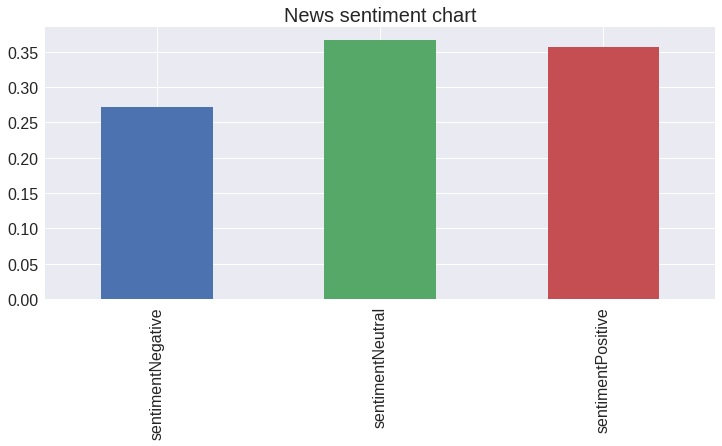

In [35]:
# Barplot on negative, neutral and positive columns.
news_train_df[['sentimentNegative', 'sentimentNeutral','sentimentPositive']].mean().plot(kind='bar')
plt.title("News sentiment chart")
plt.show()

## Restart the Kernel to run your code again
In order to combat cheating, you are only allowed to call `make_env` or iterate through `get_prediction_days` once per Kernel run.  However, while you're iterating on your model it's reasonable to try something out, change the model a bit, and try it again.  Unfortunately, if you try to simply re-run the code, or even refresh the browser page, you'll still be running on the same Kernel execution session you had been running before, and the `twosigmanews` module will still throw errors.  To get around this, you need to explicitly restart your Kernel execution session, which you can do by pressing the Restart button in the Kernel Editor's bottom Console tab:
![Restart button](https://i.imgur.com/hudu8jF.png)